In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [39]:
drive.mount('/content/drive')

# Path to root project folder
root_path = '/content/drive/My Drive/AIML_Project'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print("Contents of the directory:", os.listdir(root_path))

# .npy File Path in Local directory
file_path = os.path.join(root_path, 'Images.npy')
data = np.load(file_path, allow_pickle=True)

# Load the .npy file
data = np.load(file_path, allow_pickle=True)

# Display information about the loaded data
print(f'Type of the object: {type(data)}')
print(f'Shape of the array: {data.shape}')
print(f'Data type of the array: {data.dtype}')

Contents of the directory: ['Dwayne Johnson4.jpg', 'Benedict Cumberbatch9.jpg', 'faces_metadata.csv', 'Images.npy', 'vgg_face_weights.h5', 'PINS', 'training_images']
Type of the object: <class 'numpy.ndarray'>
Shape of the array: (393, 2)
Data type of the array: object


In [6]:
# Initialize lists to store resized images and labels
images = []
labels = []

# Iterate through each item in data
for item in data:
    image = item[0]
    label = item[1]

    # Resize image to a desired shape (e.g., 100x100)
    desired_shape = (100, 100)  # Adjust according to your requirements
    resized_image = cv2.resize(image, desired_shape)

    # Check number of channels and convert if necessary
    if resized_image.shape[-1] == 4:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGBA2RGB)
    elif resized_image.shape[-1] != 3:
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

    # Append resized image to list
    images.append(resized_image)

    # Extract label information
    # Check if any of the annotations contains a 'Face' label
    is_face = any('Face' in annotation['label'] for annotation in label)
    labels.append(1 if is_face else 0)

# Print first few labels to verify
print("First few labels:", labels[:10])

# Convert lists to numpy arrays
X = np.array(images)
Y = np.array(labels, dtype=int)  # Ensure labels are integers

# Print shapes to verify
print("Shape of X (features):", X.shape)
print("Shape of Y (labels):", Y.shape)

First few labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Shape of X (features): (393, 100, 100, 3)
Shape of Y (labels): (393,)


In [7]:
# Split indices
train_indices = slice(0, 400)  # First 400 samples for training
test_indices = slice(400, 409)  # Samples 400 to 408 for testing (9 samples)

# Split data into train and test sets
X_train = X[train_indices]
Y_train = Y[train_indices]

X_test = X[test_indices]
Y_test = Y[test_indices]

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (393, 100, 100, 3)
Shape of Y_train: (393,)
Shape of X_test: (0, 100, 100, 3)
Shape of Y_test: (0,)


In [8]:
# Calculate split indices
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

# Split data into train and test sets
X_train = X[:split_idx]
Y_train = Y[:split_idx]
X_test = X[split_idx:]
Y_test = Y[split_idx:]

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (314, 100, 100, 3)
Shape of Y_train: (314,)
Shape of X_test: (79, 100, 100, 3)
Shape of Y_test: (79,)


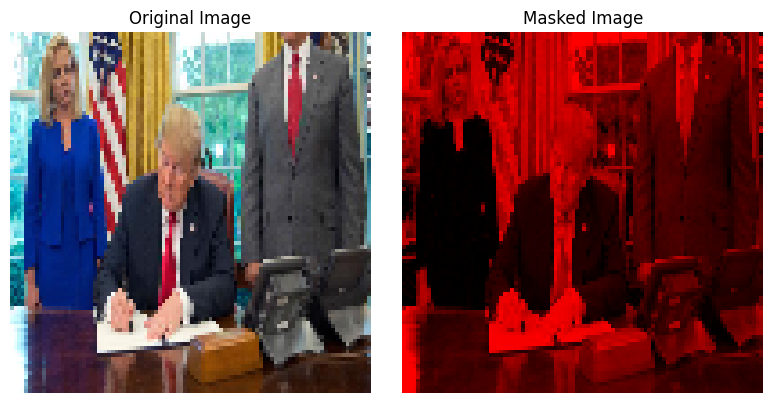

In [9]:
# Select a random index from the training set
random_index = np.random.randint(0, len(X_train))

# Retrieve the original image
original_image = X_train[random_index]

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# If you have a mask or want to perform some operation (e.g., apply a mask)
# For demonstration, let's create a simple red mask over the image
mask = np.zeros_like(original_image)
mask[:, :, 0] = 255  # Red mask

# Apply the mask (element-wise multiplication)
masked_image = cv2.bitwise_and(original_image, mask)

# Display the masked image
plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Split data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=42)

# Print shapes to verify
print("Training set shapes:", X_train.shape, Y_train.shape)
print("Validation set shapes:", X_val.shape, Y_val.shape)
print("Test set shapes:", X_test.shape, Y_test.shape)

# Ensure data types are appropriate
print("Data type of X_train:", X_train.dtype)
print("Data type of Y_train:", Y_train.dtype)
print("Data type of X_val:", X_val.dtype)
print("Data type of Y_val:", Y_val.dtype)

Training set shapes: (314, 100, 100, 3) (314,)
Validation set shapes: (63, 100, 100, 3) (63,)
Test set shapes: (16, 100, 100, 3) (16,)
Data type of X_train: uint8
Data type of Y_train: int64
Data type of X_val: uint8
Data type of Y_val: int64


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 2, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,057 (1.55 MB)

 Trainable params: 405,057 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - accuracy: 0.7846 - loss: 2.5915 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.4609e-34 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accu

In [13]:
# Assuming input image dimensions
height = 100
width = 100
channels = 3

# Input layer
inputs = Input(shape=(height, width, channels))

# Example convolutional layers
conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
conv1 = Activation('relu')(conv1)
conv2 = Conv2D(64, (3, 3), padding='same')(conv1)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(64, (3, 3), padding='same')(conv1)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(128, (3, 3), padding='same')(conv1)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(128, (3, 3), padding='same')(conv1)
conv2 = Activation('relu')(conv2)
conv2 = Conv2D(256, (3, 3), padding='same')(conv1)
conv2 = Activation('relu')(conv2)

# Output layer with sigmoid activation for binary prediction
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv2)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Custom Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

# Custom Dice loss function
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coefficient(y_true, y_pred)


# Compile the model with custom loss and metrics
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[dice_coefficient])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 100, 100, 256)       │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 100, 100, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 100, 100, 1)         │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,137 (293.50 KB)

 Trainable params: 75,137 (293.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# Train the model with callbacks
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val),
                    callbacks=[early_stopping, model_checkpoint])

# Print history keys to ensure training process is logged
print(history.history.keys())

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - dice_coefficient: 63.7747 - loss: -62.8123 - val_dice_coefficient: 62.9934 - val_loss: -62.0093
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - dice_coefficient: 63.7752 - loss: -62.8127 - val_dice_coefficient: 62.9934 - val_loss: -62.0093
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - dice_coefficient: 63.7752 - loss: -62.8127 - val_dice_coefficient: 62.9934 - val_loss: -62.0093
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - dice_coefficient: 63.7752 - loss: -62.8127 - val_dice_coefficient: 62.9935 - val_loss: -62.0093
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - dice_coefficient: 63.7752 - loss: -62.8127 - val_dice_coefficient: 62.9935 - val_loss: -62.0093
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - dice_coefficient: 63.7752 - loss: -62.8127 - val_dice_coefficient: 62.9935 - val_loss: -62.0093
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - dice_coefficient: 63.7752 - loss: -62.8127 - val_dice_

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with a different learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model again with the new architecture
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 974ms/step - accuracy: 0.7444 - loss: 0.5561 - val_accuracy: 1.0000 - val_loss: 8.0379e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.8705e-04 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.9916e-04 - val_accuracy: 1.0000 - val_loss: 0.0234


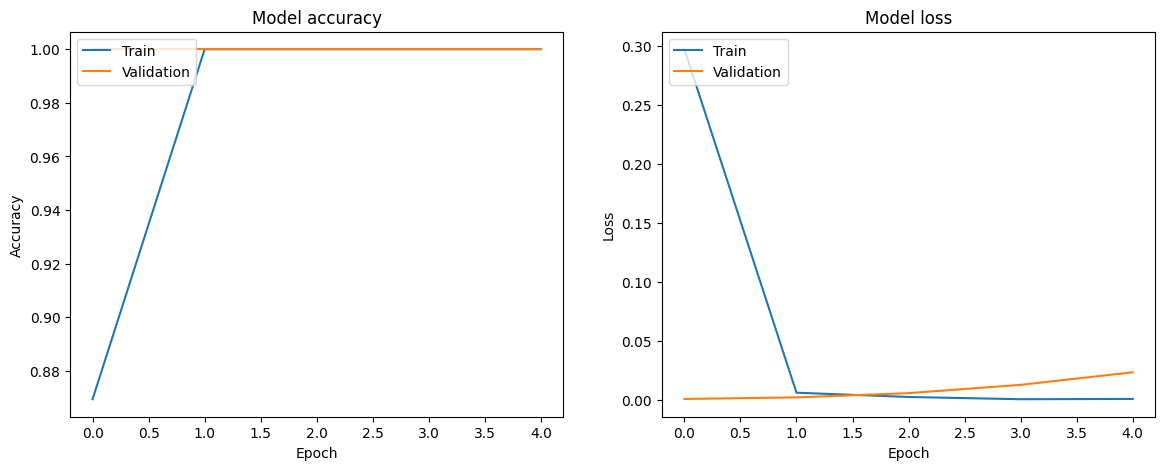

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [17]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Predict on the test set
Y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.0012
Test Loss: 0.0012
Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


              precision    recall  f1-score   support

        Mask       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



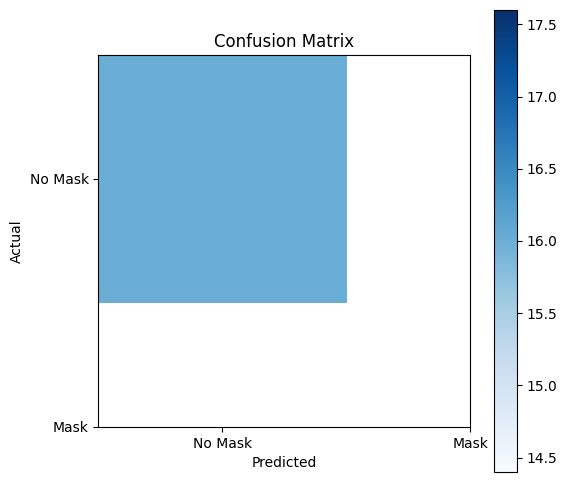

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert probabilities to binary predictions
Y_pred_labels = (Y_pred > 0.3).astype(int)

# Generate classification report
print(classification_report(Y_test, Y_pred_labels, target_names=['Mask']))

# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

plt.xticks([0, 1], ['No Mask', 'Mask'])
plt.yticks([0, 1], ['No Mask', 'Mask'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

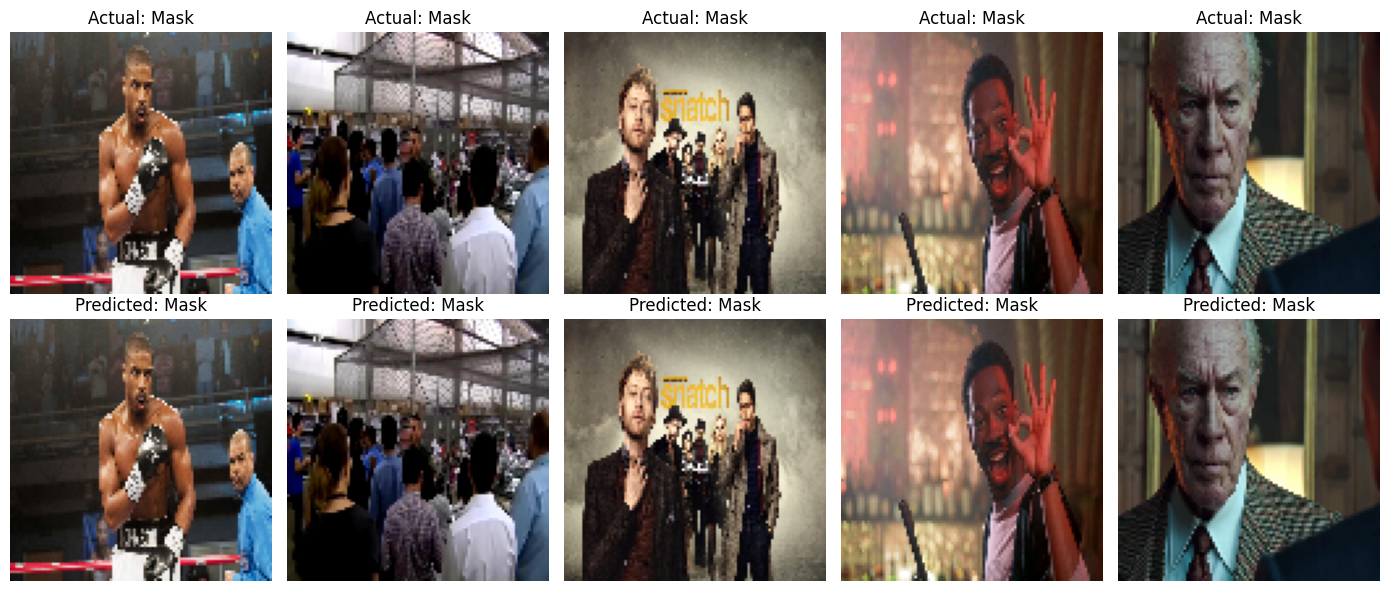

In [19]:
# Visualize predictions on a few test images
plt.figure(figsize=(14, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'Actual: {"Mask" if Y_test[i] == 1 else "No Mask"}')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(X_test[i])
    plt.title(f'Predicted: {"Mask" if Y_pred_labels[i] == 1 else "No Mask"}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
# Example threshold adjustment loop
threshold = 0.3
Y_pred_prob = model.predict(X_test)  # Assuming binary classification, adjust for your model output

# Print min and max probabilities for inspection
print(f"Min predicted probability: {np.min(Y_pred_prob)}")
print(f"Max predicted probability: {np.max(Y_pred_prob)}")

# Apply threshold to convert probabilities to binary predictions
Y_pred_binary = (Y_pred_prob > threshold).astype(int)

# Check unique predicted classes
unique_values = np.unique(Y_pred_binary)
print(f"Unique values in Y_pred_binary: {unique_values}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Min predicted probability: 0.9897858500480652
Max predicted probability: 0.9999982118606567
Unique values in Y_pred_binary: [1]


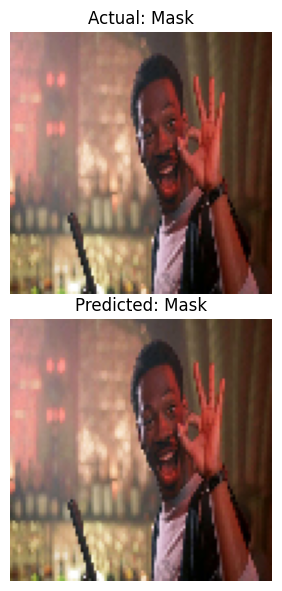

In [21]:
# Visualize predictions on a 3rd test images and predicted image
plt.figure(figsize=(14, 6))
plt.subplot(2, 5, 1)
plt.imshow(X_test[3])
plt.title(f'Actual: {"Mask" if Y_test[3] == 1 else "No Mask"}')
plt.axis('off')

plt.subplot(2, 5, 6)
plt.imshow(X_test[3])
plt.title(f'Predicted: {"Mask" if Y_pred_labels[3] == 1 else "No Mask"}')
plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
import os
import cv2
import pandas as pd

# Define the path to the folder containing the images
folder_path = os.path.join(root_path, 'training_images')
# Initialize lists to store images and their corresponding filenames
images = []
file_names = []

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    # Construct the full file path
    file_path = os.path.join(folder_path, filename)

    # Read the image using OpenCV
    image = cv2.imread(file_path)

    # Check if the image was successfully read
    if image is not None:
        # Append image and filename to lists
        images.append(image)
        file_names.append(filename)
    else:
        print(f'Failed to read image: {file_path}')

# Display number of images imported
print(f'Number of images imported: {len(images)}')

Number of images imported: 1091


In [23]:
# Initialize the face detector using Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Initialize lists to store detected faces and their metadata
faces_data = []

# Iterate through each image and detect faces
for i, image in enumerate(images):
    # Convert image to grayscale for face detection
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Iterate through detected faces and extract metadata
    for (x, y, w, h) in faces:
        # Append metadata to faces_data list
        faces_data.append({
            'Image': file_names[i],
            'Face_X': x,
            'Face_Y': y,
            'Face_Width': w,
            'Face_Height': h
        })

# Display number of detected faces
print(f'Number of faces detected: {len(faces_data)}')

Number of faces detected: 949


In [24]:
# Create a DataFrame from faces_data list
df_faces = pd.DataFrame(faces_data)

# Display the DataFrame
print(df_faces.head())

            Image  Face_X  Face_Y  Face_Width  Face_Height
0  real_00140.jpg      94     164         399          399
1  real_00437.jpg      64      93         449          449
2  real_00153.jpg     118     373          94           94
3  real_00085.jpg      48      59         470          470
4  real_00141.jpg      86     134         417          417


In [25]:
# Define the output file path
output_csv_path = os.path.join(root_path, 'faces_metadata.csv')

# Save DataFrame to CSV file
df_faces.to_csv(output_csv_path, index=False)

# Display confirmation message
print(f'DataFrame saved to {output_csv_path}')

DataFrame saved to /content/drive/My Drive/AIML_Project/faces_metadata.csv


In [42]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
root_path = '/content/drive/My Drive/AIML_Project'  # Ensure this is correct
zip_file_path = os.path.join(root_path, 'PINS.zip')
extract_dir = os.path.join(root_path, 'PINS')

print(f"Zip file path: {zip_file_path}")

# Function to create directory if it does not exist
def create_directory(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Iterate over each file
        for member in zip_ref.infolist():
            # Get the full path of the file to be extracted
            extracted_path = os.path.join(extract_dir, member.filename)
            # Create directory if it does not exist
            create_directory(os.path.dirname(extracted_path))
            # Extract the file
            zip_ref.extract(member, extract_dir)

    print("Data unzipped and loaded into session.")
except FileNotFoundError:
    print(f"File not found: {zip_file_path}")

# List all files to ensure they have been extracted
for root, dirs, files in os.walk(extract_dir):
    for file in files:
        print(os.path.join(root, file))


Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons81.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons7.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons91.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons56.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons1.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons3.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons98.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons77.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons16.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons23.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pins_Jim Parsons/Jim Parsons49.jpg
/content/drive/My Drive/AIML_Project/PINS/PINS/pin

In [43]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [44]:
metadata = []

def load_metadata(path):
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

extract_dir = os.path.join(root_path, 'PINS/PINS')
# metadata = load_metadata('images')
metadata = load_metadata(extract_dir)
print(metadata)

[/content/drive/My Drive/AIML_Project/PINS/PINS/pins_zendaya/zendaya0.jpg
 /content/drive/My Drive/AIML_Project/PINS/PINS/pins_zendaya/zendaya7.jpg
 /content/drive/My Drive/AIML_Project/PINS/PINS/pins_zendaya/zendaya11.jpg
 ...
 /content/drive/My Drive/AIML_Project/PINS/PINS/pins_Aaron Paul/Aaron Paul22_265.jpg
 /content/drive/My Drive/AIML_Project/PINS/PINS/pins_Aaron Paul/Aaron Paul145_256.jpg
 /content/drive/My Drive/AIML_Project/PINS/PINS/pins_Aaron Paul/Aaron Paul188_255.jpg]


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

# Initialize the model
model = vgg_face()

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)       │ (None, 226, 226, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 226, 226, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_2 (ZeroPadding2D)     │ (None, 114, 114, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_3 (ZeroPadding2D)     │ (None, 114, 114, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_4 (ZeroPadding2D)     │ (None, 58, 58, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_5 (ZeroPadding2D)     │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_6 (ZeroPadding2D)     │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_7 (ZeroPadding2D)     │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_8 (ZeroPadding2D)     │ (None, 30, 30, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
import h5py
vgg_face_weights = os.path.join(root_path, 'vgg_face_weights.h5')
model.load_weights(vgg_face_weights)

In [47]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
(2622,)


In [48]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [50]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

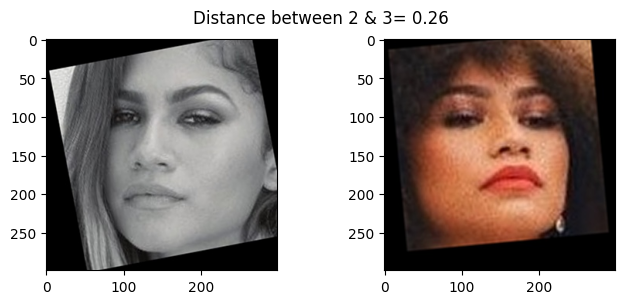

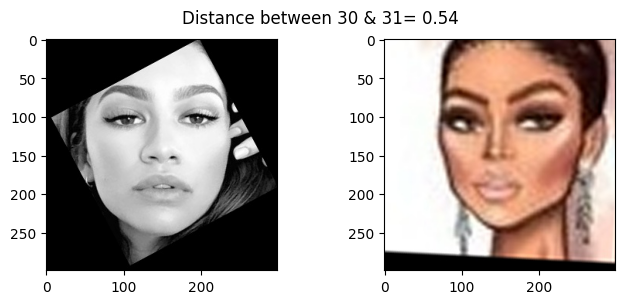

In [51]:
show_pair(2, 3)
show_pair(30, 31)

In [52]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(le.classes_)
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman'
 'pins_Neil Patrick Harris' 'pins_Paul Rudd' 'pins_Pedro Alonso'
 'pins_Peter Dinklage' 'pins_R

In [54]:
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [55]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

y_predict = clf.predict(X_test_pca)
y_predict_encoded = le.inverse_transform(y_predict)

print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict :  [61 61 61 ... 76 76 76]
y_test_encoded :  [99 99 99 ...  0  0  0]
y_predict shape :  (1197,)
y_test_encoded shape :  (1197,)


In [56]:
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
accuracy_score(y_test_encoded, y_predict)

0.04594820384294068

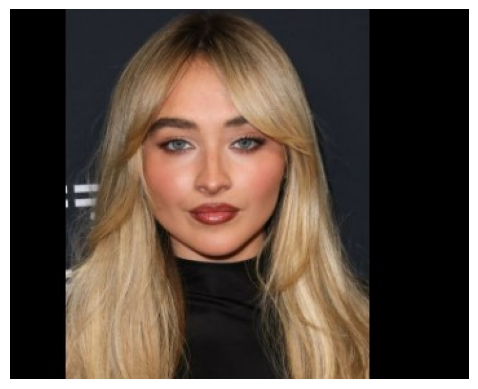

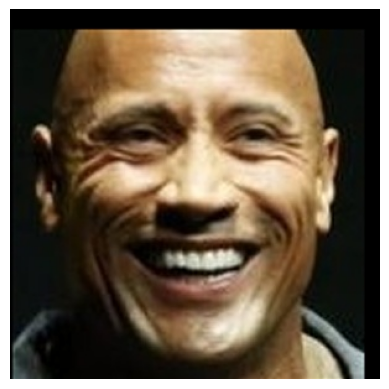

In [62]:
import matplotlib.pyplot as plt

def display_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Define paths to test images
test_images = ['sabrina carpenter.jpg', 'Dwayne Johnson4.jpg']

for test_image in test_images:
    test_image_path = os.path.join(root_path, test_image)
    display_image(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


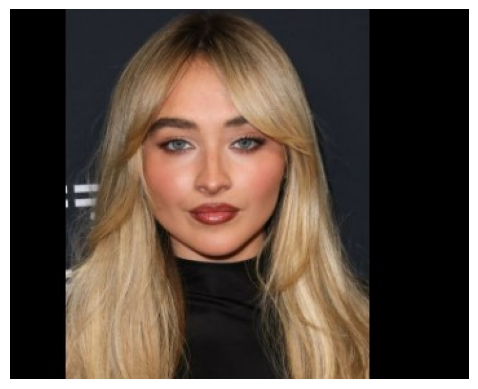

Predicted identity for sabrina carpenter.jpg: pins_Willa Holland


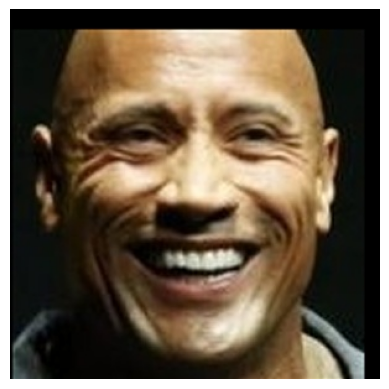

Predicted identity for Dwayne Johnson4.jpg: pins_Willa Holland
Test Image: sabrina carpenter.jpg
Predicted Identity: pins_Willa Holland
Test Image: Dwayne Johnson4.jpg
Predicted Identity: pins_Willa Holland


In [63]:
# Load and preprocess the test images
def preprocess_image(image_path):
    img = load_image(image_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize=(224, 224))
    return img

# Generate embeddings for the test images using the VGG Face model
test_embeddings = np.zeros((len(test_images), 2622))
for i, test_image in enumerate(test_images):
    test_image_path = os.path.join(root_path, test_image)
    img = preprocess_image(test_image_path)
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    test_embeddings[i] = embedding_vector

# Apply PCA transformation to the test embeddings
test_embeddings_pca = pca.transform(scaler.transform(test_embeddings))

# Use the trained SVM model to predict the identities of the test images
predictions = clf.predict(test_embeddings_pca)
predicted_names = le.inverse_transform(predictions)

# Display the test images along with their predicted identities
for i, test_image in enumerate(test_images):
    test_image_path = os.path.join(root_path, test_image)
    display_image(test_image_path)
    print(f"Predicted identity for {test_image}: {predicted_names[i]}")

# Show the predictions
for i, test_image in enumerate(test_images):
    print(f'Test Image: {test_image}')
    print(f'Predicted Identity: {predicted_names[i]}')